In [ ]:
import os
import json
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter

# Define base folder paths
base_folder = '/content/drive/MyDrive/dataset/categories'  # Base folder with categories
query_folder = '/content/drive/MyDrive/dataset/query_images'  # Folder for query images

# Fonction pour calculer les histogrammes de couleurs
def calculate_color_histogram(image_path):
    img = cv2.imread(image_path)
    chans = cv2.split(img)
    colors = ("b", "g", "r")
    histograms = {}
    for chan, color in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms[color] = hist.tolist()
    return histograms

# Fonction pour trouver les couleurs dominantes
def find_dominant_colors(image_path, k=20, threshold=0.05):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img)
    counts = Counter(kmeans.labels_)
    total_pixels = sum(counts.values())
    return [kmeans.cluster_centers_[idx].tolist() for idx, count in counts.items() if count / total_pixels > threshold]

# Fonction pour calculer les descripteurs de texture basés sur les filtres de Gabor
def calculate_gabor_descriptors(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gabor_kernels = []
    responses = []
    for theta in [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]:  # 4 orientations
        for sigma in [1, 3]:  # 2 échelles
            kernel = cv2.getGaborKernel((21, 21), sigma, theta, 10, 0.5, 0, ktype=cv2.CV_32F)
            gabor_kernels.append(kernel)
            filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            responses.append(np.mean(filtered_img))
    return responses

# Fonction pour calculer les moments de Hu pour le plus grand contour
def calculate_hu_moments(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea) if contours else None
    if largest_contour is not None:
        hu_moments = cv2.HuMoments(cv2.moments(largest_contour)).flatten()
        return hu_moments.tolist()
    return [0] * 7  # Si aucun contour n'est trouvé, retourner des zéros

# Fonction pour calculer l'énergie de texture basée sur une matrice de cooccurrence
def calculate_texture_energy(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    energy = 0
    for angle in [0, np.pi/4, np.pi/2, 3*np.pi/4]:  # Différentes orientations
        kernel = cv2.getGaborKernel((21, 21), 3, angle, 10, 0.5, 0, ktype=cv2.CV_32F)
        filtered_img = cv2.filter2D(img, cv2.CV_32F, kernel)
        energy += np.sum(filtered_img ** 2)
    return energy

# Fonction pour calculer la circularité
def calculate_circularity(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea) if contours else None
    if largest_contour is not None:
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        if perimeter > 0:
            circularity = 4 * np.pi * (area / (perimeter ** 2))
            return circularity
    return 0  # Si aucun contour n'est trouvé

# Initialiser le dictionnaire pour stocker les descripteurs
descriptor_data = {}

# Parcourir les catégories et calculer les descripteurs
for category in os.listdir(base_folder):
    category_path = os.path.join(base_folder, category)
    if os.path.isdir(category_path):  # Vérifier si c'est un dossier
        descriptor_data[category] = {}
        for filename in os.listdir(category_path):
            if filename.endswith(('.jpg', '.png')):
                img_path = os.path.join(category_path, filename)
                # Calculer les descripteurs
                histograms = calculate_color_histogram(img_path)
                dominant_colors = find_dominant_colors(img_path)
                gabor_descriptors = calculate_gabor_descriptors(img_path)
                hu_moments = calculate_hu_moments(img_path)
                texture_energy = calculate_texture_energy(img_path)
                circularity = calculate_circularity(img_path)
                # Stocker les descri1pteurs
                descriptor_data[category][filename] = {
                    "histogram": histograms,
                    "dominant_colors": dominant_colors,
                    "gabor_descriptors": gabor_descriptors,
                    "hu_moments": hu_moments,
                    "texture_energy": texture_energy,
                    "circularity": circularity
                }

# Sauvegarder les descripteurs dans un fichier JSON
with open("image_descriptors.json", "w") as json_file:
    json.dump(descriptor_data, json_file)

# Sauvegarder les descripteurs dans un fichier JSON sur Google Drive
output_path = '/content/drive/MyDrive/dataset/image_descriptors.json'  # Remplacez par le chemin souhaité dans Google Drive
with open(output_path, "w") as json_file:
    json.dump(descriptor_data, json_file)

print(f"JSON file successfully saved to {output_path}")


JSON file successfully saved to /content/drive/MyDrive/dataset/image_descriptors.json


In [ ]:
!pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 21.3 MB/s eta 0:00:00


In [ ]:
# MongoDB connection
client = MongoClient("mongodb://localhost:27017")  # Replace with your connection string
db = client['image_database']  # Database name
collection = db['image_descriptors']  # Collection name

# Dataset folder
dataset_folder = '/dataset/categories'

# Traverse dataset and calculate descriptors
for category in os.listdir(dataset_folder):
    category_path = os.path.join(dataset_folder, category)
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            if img_name.endswith(('.jpg', '.png')):
                img_path = os.path.join(category_path, img_name)

                # Calculate descriptors
                descriptors = {
                    "category": category,
                    "image_name": img_name,
                    "histogram": calculate_color_histogram(img_path),
                    "dominant_colors": find_dominant_colors(img_path),
                    "gabor": calculate_gabor_descriptors(img_path),
                    "hu_moments": calculate_hu_moments(img_path),
                    "texture_energy": calculate_texture_energy(img_path),
                    "circularity": calculate_circularity(img_path)
                }

                # Save to MongoDB
                collection.insert_one(descriptors)
print("Descriptors saved to MongoDB successfully!")

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to plot similar images
def plot_similar_images(metric_distances, title):
    plt.figure(figsize=(15, 8))
    plt.suptitle(title, fontsize=20)

    # Display chosen image
    chosen_img = Image.open(os.path.join(query_folder, filename))
    plt.subplot(2, 4, 1)
    plt.imshow(chosen_img)
    plt.axis('off')
    plt.title("Chosen Image")

    # Display similar images
    for i, (image_name, dist) in enumerate(metric_distances, start=2):
        similar_img = Image.open(os.path.join(base_folder, image_name))
        plt.subplot(2, 4, i)
        plt.imshow(similar_img)
        plt.axis('off')
        plt.title(f"{image_name}\nDist: {dist:.4f}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

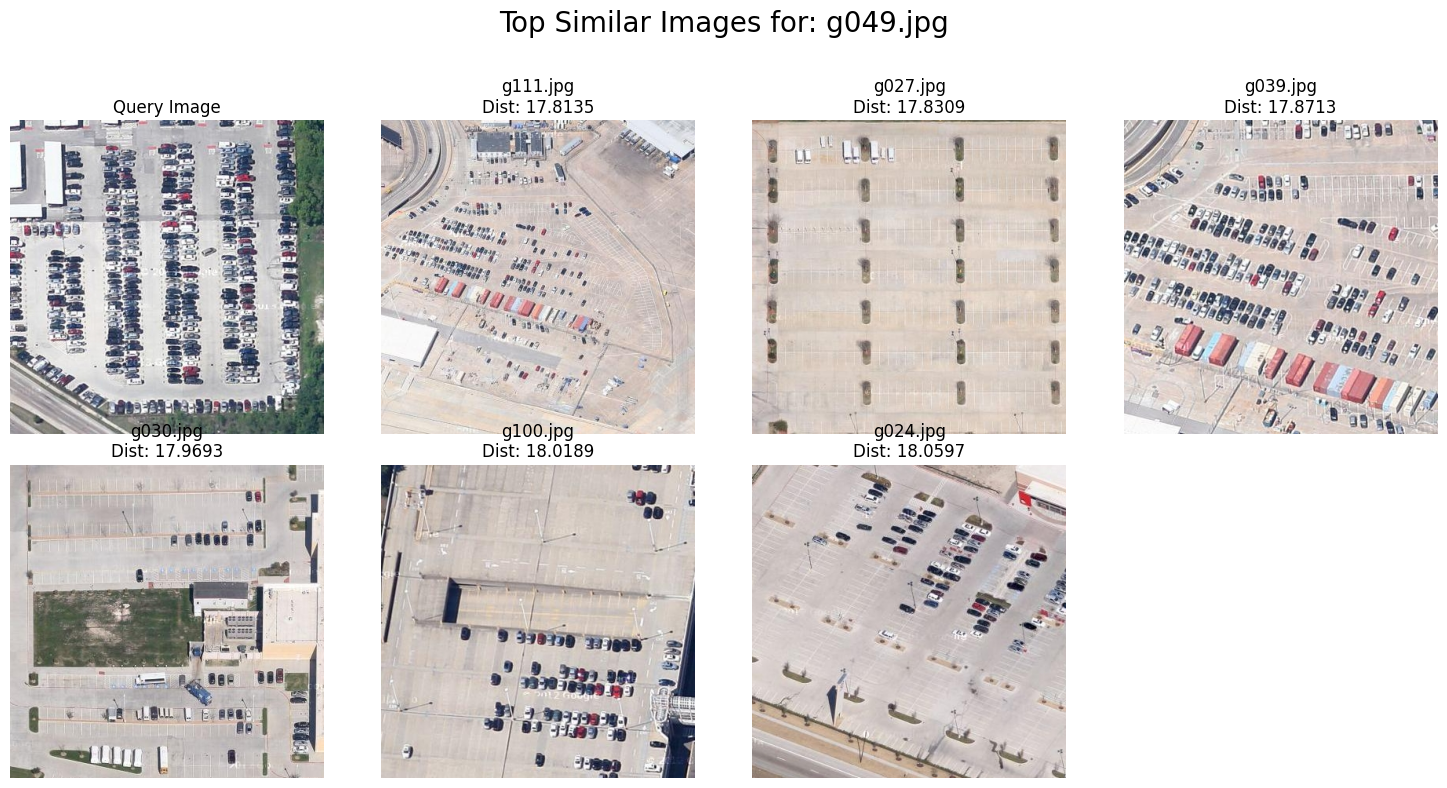

In [ ]:
import json
import random
import cv2
import os
import numpy as np
from scipy.spatial import distance
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image

# Define query folder
query_folder = '/content/drive/MyDrive/dataset/query_images'

# Load descriptors from JSON
with open("image_descriptors.json", "r") as json_file:
    descriptor_data = json.load(json_file)

# Define similarity functions
def bhattacharyya_distance(hist1, hist2):
    return sum(cv2.compareHist(np.array(hist1[color], dtype=np.float32),
                               np.array(hist2[color], dtype=np.float32),
                               cv2.HISTCMP_BHATTACHARYYA) for color in ("b", "g", "r"))

def dominant_color_distance(colors1, colors2):
    return distance.cdist(np.array(colors1), np.array(colors2), 'euclidean').mean()

def gabor_distance(gabor1, gabor2):
    return distance.euclidean(np.array(gabor1).flatten(), np.array(gabor2).flatten())

def hu_moments_distance(hu1, hu2):
    return distance.euclidean(np.array(hu1), np.array(hu2))

# Descriptor computation functions
def calculate_color_histogram(image_path):
    img = cv2.imread(image_path)
    chans = cv2.split(img)
    colors = ("b", "g", "r")
    histograms = {}
    for chan, color in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histograms[color] = hist.tolist()
    return histograms

def find_dominant_colors(image_path, k=20, threshold=0.05):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img)
    counts = Counter(kmeans.labels_)
    total_pixels = sum(counts.values())
    return [kmeans.cluster_centers_[idx].tolist() for idx, count in counts.items() if count / total_pixels > threshold]

# Fonction pour calculer les descripteurs de texture basés sur les filtres de Gabor
def calculate_gabor_descriptors(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gabor_kernels = []
    responses = []
    for theta in [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]:  # 4 orientations
        for sigma in [1, 3]:  # 2 échelles
            kernel = cv2.getGaborKernel((21, 21), sigma, theta, 10, 0.5, 0, ktype=cv2.CV_32F)
            gabor_kernels.append(kernel)
            filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            responses.append(np.mean(filtered_img))
    return responses

def calculate_hu_moments(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    moments = cv2.moments(img)
    hu_moments = cv2.HuMoments(moments).flatten()
    return -np.sign(hu_moments) * np.log10(np.abs(hu_moments))  # Log transform for scale invariance

# Randomly select a query image
query_images = [f for f in os.listdir(query_folder) if f.endswith(('.jpg', '.png'))]
selected_image = random.choice(query_images)
selected_image_path = os.path.join(query_folder, selected_image)

# Compute descriptors for the query image
query_descriptors = {
    "histogram": calculate_color_histogram(selected_image_path),
    "dominant_colors": find_dominant_colors(selected_image_path),
    "gabor_descriptors": calculate_gabor_descriptors(selected_image_path),
    "hu_moments": calculate_hu_moments(selected_image_path)
}

# Calculate similarity
similarities = []
for category, images in descriptor_data.items():
    for img_name, descriptors in images.items():
        hist_dist = bhattacharyya_distance(query_descriptors["histogram"], descriptors["histogram"])
        color_dist = dominant_color_distance(query_descriptors["dominant_colors"], descriptors["dominant_colors"])
        gabor_dist = gabor_distance(query_descriptors["gabor_descriptors"], descriptors["gabor_descriptors"])
        hu_dist = hu_moments_distance(query_descriptors["hu_moments"], descriptors["hu_moments"])

        # Weighted combination of all distances
        total_distance = 0.4 * hist_dist + 0.3 * color_dist + 0.2 * gabor_dist + 0.1 * hu_dist
        similarities.append((category, img_name, total_distance))

# Sort results and display top matches
similarities = sorted(similarities, key=lambda x: x[2])[:6]

# Display the images
plt.figure(figsize=(15, 8))
plt.suptitle(f"Top Similar Images for: {selected_image}", fontsize=20)

# Show the query image
query_img = Image.open(selected_image_path)
plt.subplot(2, 4, 1)
plt.imshow(query_img)
plt.axis('off')
plt.title("Query Image")

# Show the top matches
for i, (category, img_name, dist) in enumerate(similarities, start=2):
    category_path = os.path.join('/content/drive/MyDrive/dataset/categories', category)
    similar_img_path = os.path.join(category_path, img_name)
    similar_img = Image.open(similar_img_path)
    plt.subplot(2, 4, i)
    plt.imshow(similar_img)
    plt.axis('off')
    plt.title(f"{img_name}\nDist: {dist:.4f}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
